In [1]:
import torch
import torch.utils.data
from torch import nn
from torch.nn import functional as F

from ignite.engine import Events, Engine
from ignite.metrics import Accuracy, Loss

import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
class Model_bilinear(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # i is batch, m is embedding_size, n is num_embeddings (classes)
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        
        diff = z - embeddings.unsqueeze(0)            
        #y_pred = (- diff**2).mean(1).div(2 * self.sigma**2).exp()

        return diff

    def forward(self, x):
        z = self.embed(x)
        diff = self.bilinear(z)
        
        return z, diff

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        # normalizing value per class, assumes y is one_hot encoded
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        # compute sum of embeddings on class by class basis
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum

In [3]:
np.random.seed(0)
torch.manual_seed(0)

l_gradient_penalty = 1.0

# Moons
noise = 0.1
X_train, y_train = sklearn.datasets.make_moons(n_samples=1500, noise=noise)
X_test, y_test = sklearn.datasets.make_moons(n_samples=200, noise=noise)

# X_train -= 10
# X_test -= 10

num_classes = 2
batch_size = 64

model = Model_bilinear(20, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


def calc_gradient_penalty(x, y_pred):
    gradients = torch.autograd.grad(
            outputs=y_pred,
            inputs=x,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True,
        )[0]


    gradients = gradients.flatten(start_dim=1)
    
    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()
    
    # One sided penalty - down
#     gradient_penalty = F.relu(grad_norm - 1).mean()

    return gradient_penalty


def output_transform_acc(output):
    y_pred, y, x, z = output
    
    y = torch.argmax(y, dim=1)
        
    return y_pred, y


def output_transform_bce(output):
    y_pred, y, x, z = output

    return y_pred, y


def output_transform_gp(output):
    y_pred, y, x, z = output

    return x, y_pred


def step(engine, batch):
    model.train()
    optimizer.zero_grad()
    
    x, y = batch
    x.requires_grad_(True)
    
    z, diff = model(x)
    y_pred = (- diff**2).mean(1).div(2 * 0.3**2).exp()
    
    
    loss1 =  F.binary_cross_entropy(y_pred, y)
    loss2 = l_gradient_penalty * calc_gradient_penalty(x, y_pred)
    
    loss = loss1 + loss2
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        model.update_embeddings(x, y)
    
    return loss.item()


def eval_step(engine, batch):
    model.eval()

    x, y = batch

    x.requires_grad_(True)

    z, diff = model(x)
    y_pred = (- diff**2).mean(1).div(2 * 0.3**2).exp()

    return y_pred, y, x, z
    

trainer = Engine(step)
evaluator = Engine(eval_step)

metric = Accuracy(output_transform=output_transform_acc)
metric.attach(evaluator, "accuracy")

metric = Loss(F.binary_cross_entropy, output_transform=output_transform_bce)
metric.attach(evaluator, "bce")

metric = Loss(calc_gradient_penalty, output_transform=output_transform_gp)
metric.attach(evaluator, "gp")


ds_train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), F.one_hot(torch.from_numpy(y_train)).float())
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last=True)

ds_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(), F.one_hot(torch.from_numpy(y_test)).float())
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=200, shuffle=False)

@trainer.on(Events.EPOCH_COMPLETED)
def log_results(trainer):
    evaluator.run(dl_test)
    metrics = evaluator.state.metrics

    print("Test Results - Epoch: {} Acc: {:.4f} BCE: {:.2f} GP {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['bce'], metrics['gp']))

In [4]:
trainer.run(dl_train, max_epochs=30)

Test Results - Epoch: 1 Acc: 0.8350 BCE: 0.47 GP 0.21
Test Results - Epoch: 2 Acc: 0.8750 BCE: 0.36 GP 0.12
Test Results - Epoch: 3 Acc: 0.9100 BCE: 0.29 GP 0.06
Test Results - Epoch: 4 Acc: 0.9400 BCE: 0.25 GP 0.05
Test Results - Epoch: 5 Acc: 0.9700 BCE: 0.18 GP 0.09
Test Results - Epoch: 6 Acc: 0.9900 BCE: 0.14 GP 0.05
Test Results - Epoch: 7 Acc: 0.9950 BCE: 0.13 GP 0.06
Test Results - Epoch: 8 Acc: 0.9900 BCE: 0.12 GP 0.03
Test Results - Epoch: 9 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 10 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 11 Acc: 0.9950 BCE: 0.11 GP 0.03
Test Results - Epoch: 12 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 13 Acc: 0.9950 BCE: 0.10 GP 0.02
Test Results - Epoch: 14 Acc: 0.9950 BCE: 0.11 GP 0.03
Test Results - Epoch: 15 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoch: 16 Acc: 1.0000 BCE: 0.09 GP 0.05
Test Results - Epoch: 17 Acc: 0.9950 BCE: 0.09 GP 0.04
Test Results - Epoch: 18 Acc: 0.9950 BCE: 0.10 GP 0.03
Test Results - Epoc

State:
	iteration: 690
	epoch: 30
	epoch_length: 23
	max_epochs: 30
	output: 0.10658571124076843
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [5]:
torch.save(model.state_dict(), 'two_moons_std.pth')

In [6]:
import copy
from torch.quantization import quantize_fx

quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)

    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
    
state_dict = model_quantized.state_dict()
for name, value in state_dict.items():
    print(name)
print(model_quantized)

W
fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
fc1.scale
fc1.zero_point
fc1._packed_params.dtype
fc1._packed_params._packed_params
fc2.scale
fc2.zero_point
fc2._packed_params.dtype
fc2._packed_params._packed_params
fc3.scale
fc3.zero_point
fc3._packed_params.dtype
fc3._packed_params._packed_params
GraphModule(
  (fc1): QuantizedLinearReLU(in_features=2, out_features=20, scale=0.012785964645445347, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinearReLU(in_features=20, out_features=20, scale=0.006874776445329189, zero_point=0, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=20, out_features=20, scale=0.01663178578019142, zero_point=77, qscheme=torch.per_channel_affine)
)



def forward(self, x):
    fc1_input_scale_0 = self.fc1_input_scale_0
    fc1_input_zero_point_0 = self.fc1_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1536: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [7]:
torch.save(model_quantized.state_dict(), 'two_moons_quant.pth')

In [8]:
class bilin(nn.Module):
    def __init__(self, features, num_embeddings):
        super().__init__()
        
        self.gamma = 0.99
        self.sigma = 0.3
        
        embedding_size = 10
        
        self.fc1 = nn.Linear(2, features)
        self.fc2 = nn.Linear(features, features)
        self.fc3 = nn.Linear(features, features)
        
        self.W = nn.Parameter(torch.normal(torch.zeros(embedding_size, num_embeddings, features), 1))
        
        self.register_buffer('N', torch.ones(num_embeddings) * 20)
        self.register_buffer('m', torch.normal(torch.zeros(embedding_size, num_embeddings), 1))
        
        self.m = self.m * self.N.unsqueeze(0)

    def embed(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.einsum('ij,mnj->imn', x, self.W)
        
        return x

    def bilinear(self, z):
        embeddings = self.m / self.N.unsqueeze(0)
        diff = z - embeddings.unsqueeze(0)            
        return diff

    def forward(self, x):
        z = self.embed(x)
        diff = self.bilinear(z)
        return z, diff

    def update_embeddings(self, x, y):
        z = self.embed(x)
        
        self.N = torch.max(self.gamma * self.N + (1 - self.gamma) * y.sum(0), torch.ones_like(self.N))
        
        features_sum = torch.einsum('ijk,ik->jk', z, y)
        
        self.m = self.gamma * self.m + (1 - self.gamma) * features_sum
        
        
model = bilin(20, num_classes)
model.load_state_dict(torch.load('two_moons_std.pth'))  

<All keys matched successfully>

/tmp/ipykernel_14535/1294061587.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


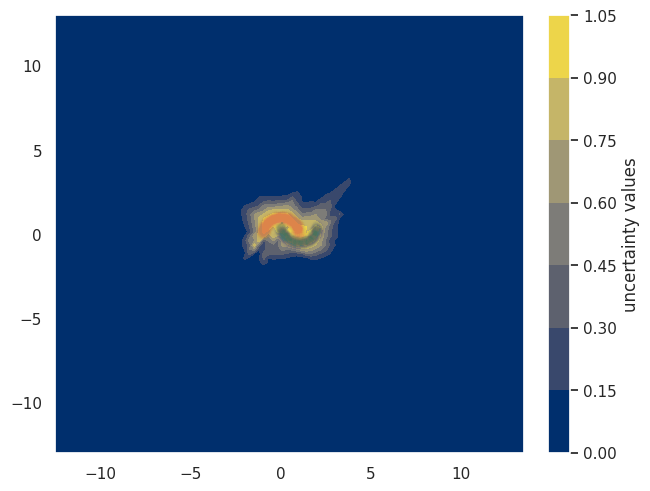

In [9]:
domain = 13
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])

X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
#X_vis -= 10
mask = y_vis.astype(np.bool)



with torch.no_grad():
    z, diff = model(torch.from_numpy(X_grid).float())
    output = (- diff**2).median(1)[0].div(2 * 0.3**2).exp()
    confidence = output.max(1)[0].numpy()
z = confidence.reshape(xx.shape)
#plt.figure()
fig1, ax2 = plt.subplots(layout='constrained')
CS = ax2.contourf(x_lin, y_lin, z, cmap='cividis')
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('uncertainty values')
ax2.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.01)
ax2.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.01)

In [10]:
quantise = True
if quantise:
    dataiter = iter(dl_train)
    images, labels = next(dataiter)
    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, images)

    with torch.inference_mode():
        for _ in range(10):
            images, labels = next(dataiter)
            model_prepared(images)
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
    
state_dict = model_quantized.state_dict()
for name, value in state_dict.items():
    print(name)
print(model_quantized)
model_quantized.load_state_dict(torch.load('two_moons_quant.pth'))

W
fc1_input_scale_0
fc1_input_zero_point_0
_tensor_constant0
fc1.scale
fc1.zero_point
fc1._packed_params.dtype
fc1._packed_params._packed_params
fc2.scale
fc2.zero_point
fc2._packed_params.dtype
fc2._packed_params._packed_params
fc3.scale
fc3.zero_point
fc3._packed_params.dtype
fc3._packed_params._packed_params
GraphModule(
  (fc1): QuantizedLinearReLU(in_features=2, out_features=20, scale=0.012941916473209858, zero_point=0, qscheme=torch.per_channel_affine)
  (fc2): QuantizedLinearReLU(in_features=20, out_features=20, scale=0.006707231048494577, zero_point=0, qscheme=torch.per_channel_affine)
  (fc3): QuantizedLinear(in_features=20, out_features=20, scale=0.01656913384795189, zero_point=77, qscheme=torch.per_channel_affine)
)



def forward(self, x):
    fc1_input_scale_0 = self.fc1_input_scale_0
    fc1_input_zero_point_0 = self.fc1_input_zero_point_0
    quantize_per_tensor = torch.quantize_per_tensor(x, fc1_input_scale_0, fc1_input_zero_point_0, torch.quint8);  x = fc1_input_scale_

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:335: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


<All keys matched successfully>

/tmp/ipykernel_14535/3572517744.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = y_vis.astype(np.bool)


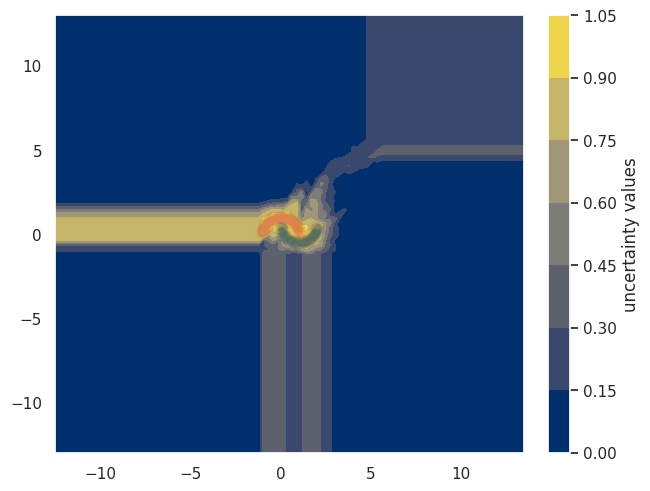

In [11]:
domain = 13
x_lin = np.linspace(-domain+0.5, domain+0.5, 100)
y_lin = np.linspace(-domain, domain, 100)

xx, yy = np.meshgrid(x_lin, y_lin)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])



X_vis, y_vis = sklearn.datasets.make_moons(n_samples=1000, noise=noise)
#X_vis -= 10
mask = y_vis.astype(np.bool)

with torch.no_grad():
    z, diff = model_quantized(torch.from_numpy(X_grid).float())
    output = (- diff**2).median(1)[0].div(2 * 0.3**2).exp()
    confidence = output.max(1)[0].numpy()


z = confidence.reshape(xx.shape)

fig1, ax2 = plt.subplots(layout='constrained')
CS = ax2.contourf(x_lin, y_lin, z, cmap='cividis')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('uncertainty values')

plt.scatter(X_vis[mask,0], X_vis[mask,1], alpha=0.01)
plt.scatter(X_vis[~mask,0], X_vis[~mask,1], alpha=0.01)

In [6]:
import numpy as np
np.finfo(np.float32).eps

1.1920929e-07